## layout

#### [Azure Document Intelligence Layout 설명 문서](https://learn.microsoft.com/ko-kr/azure/ai-services/document-intelligence/prebuilt/layout?view=doc-intel-4.0.0&tabs=rest%2Csample-code)

-   텍스트,테이블,선택 표시 및 문서 구조를 추출


In [11]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
from io import BytesIO

import os


# 환경변수 설정
endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
key = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# 클라이언트 초기화
document_intelligence_client = DocumentIntelligenceClient(
    endpoint=endpoint, credential=AzureKeyCredential(key)
)

print("Azure Document Intelligence 클라이언트 초기화 완료")

Azure Document Intelligence 클라이언트 초기화 완료


### 레이아웃 분석 후 시각화 처리


In [12]:
# 유틸리티 함수 정의
def format_bounding_box(bounding_box):
    if not bounding_box:
        return "N/A"
    reshaped_bounding_box = np.array(bounding_box).reshape(-1, 2)
    return ", ".join(["[{}, {}]".format(x, y) for x, y in reshaped_bounding_box])


def display_local_image(file_path):
    """이미지 파일을 표시합니다."""
    # PDF가 아닌 이미지인 경우에만 표시
    if file_path.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
        image = Image.open(file_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        plt.title("원본 문서")
        plt.show()
    else:
        print("PDF 문서는 표시안됨")


def visualize_layout_results(result, image_path=None):
    """레이아웃 분석 결과를 시각화합니다."""
    # 문서에 필기체 포함 여부 확인
    for idx, style in enumerate(result.styles):
        print(
            f"문서에는 {'필기체' if style.is_handwritten else '인쇄체'} 내용이 포함되어 있습니다."
        )

    # 텍스트 라인 출력
    print("\n=== 텍스트 라인 ===")
    for page in result.pages:
        print(f"\n--- 페이지 #{page.page_number} ---")
        print(f"페이지 크기: 너비 {page.width}, 높이 {page.height}, 단위: {page.unit}")

        for line_idx, line in enumerate(page.lines[:10]):  # 처음 10개 라인만 표시
            print(f"  라인 #{line_idx}: '{line.content}'")

        if len(page.lines) > 10:
            print(f"  ... 그 외 {len(page.lines) - 10}개 라인")

    # 선택 마크 출력
    print("\n=== 선택 마크 ===")
    for page in result.pages:
        if page.selection_marks:
            print(f"페이지 #{page.page_number}의 선택 마크:")
            for idx, mark in enumerate(page.selection_marks):
                print(
                    f"  선택 마크 #{idx}: 상태 '{mark.state}', 신뢰도 {mark.confidence:.4f}"
                )
        else:
            print(f"페이지 #{page.page_number}에는 선택 마크가 없습니다.")

    # 테이블 정보 출력
    print("\n=== 테이블 ===")
    if result.tables:
        for table_idx, table in enumerate(result.tables):
            print(f"테이블 #{table_idx}: {table.row_count}행 x {table.column_count}열")

            # 첫 5개 셀만 출력
            print("  샘플 셀 내용:")
            for i, cell in enumerate(table.cells[:5]):
                print(
                    f"    셀[{cell.row_index}][{cell.column_index}]: '{cell.content}'"
                )

            if len(table.cells) > 5:
                print(f"    ... 그 외 {len(table.cells) - 5}개 셀")
    else:
        print("문서에 테이블이 없습니다.")

    # 이미지인 경우 시각화
    if image_path and image_path.lower().endswith(
        (".png", ".jpg", ".jpeg", ".bmp", ".gif")
    ):
        try:
            image = Image.open(image_path)
            draw = ImageDraw.Draw(image)

            # 첫 페이지 텍스트 라인 표시 (빨간색)
            for page in result.pages:
                for line in page.lines:
                    # 수정된 부분: polygon이 [x1, y1, x2, y2, ...] 형태인 경우
                    if line.polygon and isinstance(line.polygon[0], (int, float)):
                        # 인덱스를 2개씩 그룹화하여 (x,y) 좌표쌍 생성
                        points = [
                            (line.polygon[i], line.polygon[i + 1])
                            for i in range(0, len(line.polygon), 2)
                        ]
                    else:
                        # 기존 방식 시도 (polygon이 객체 목록인 경우)
                        try:
                            points = [(p.x, p.y) for p in line.polygon]
                        except AttributeError:
                            # 둘 다 실패하면 건너뛰기
                            continue

                    draw.polygon(points, outline="red")

            # 테이블 표시 (파란색)
            for table in result.tables:
                for cell in table.cells:
                    if cell.bounding_regions:
                        # 수정된 부분: 동일한 방식으로 polygon 처리
                        region_polygon = cell.bounding_regions[0].polygon
                        if region_polygon and isinstance(
                            region_polygon[0], (int, float)
                        ):
                            points = [
                                (region_polygon[i], region_polygon[i + 1])
                                for i in range(0, len(region_polygon), 2)
                            ]
                        else:
                            try:
                                points = [(p.x, p.y) for p in region_polygon]
                            except AttributeError:
                                continue

                        draw.polygon(points, outline="blue")

            plt.figure(figsize=(12, 12))
            plt.imshow(image)
            plt.axis("off")
            plt.title("레이아웃 분석 결과")
            plt.show()
        except Exception as e:
            print(f"결과 시각화 중 오류 발생: {e}")

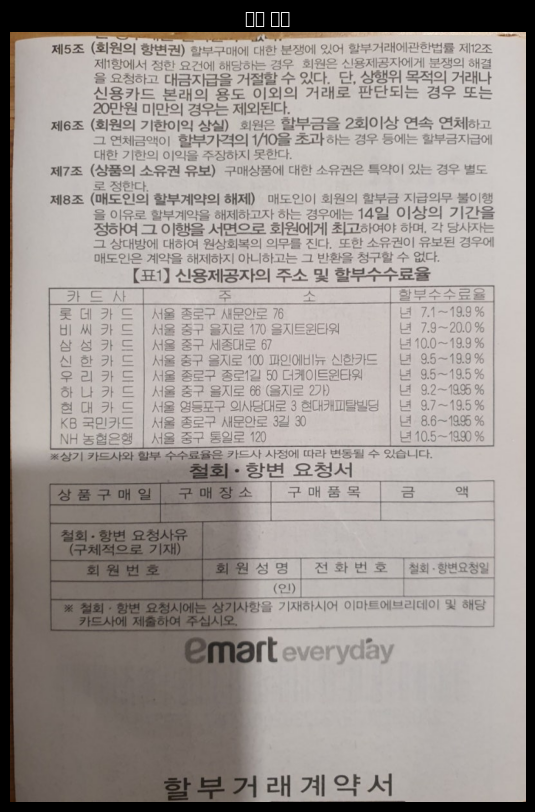

로컬 파일 '../samples/receipt2.jpg' 분석 중...
분석 완료: 1 페이지 처리됨

=== 텍스트 라인 ===

--- 페이지 #1 ---
페이지 크기: 너비 800.0, 높이 1195.0, 단위: LengthUnit.PIXEL
  라인 #0: '제5조 (회원의 항변권) 할부구매에 대한 분쟁에 있어 할부거래에관한법률 제12조'
  라인 #1: '제1항에서 정한 요건에 해당하는 경우 회원은 신용제공자에게 분쟁의 해결'
  라인 #2: '을 요청하고 대금지급을 거절할 수 있다. 단, 상행위 목적의 거래나'
  라인 #3: '신용카드 본래의 용도 이외의 거래로 판단되는 경우 또는'
  라인 #4: '20만원 미만의 경우는 제외된다.'
  라인 #5: '제6조 (회원의 기한이익 상실) 회원은 할부금을 2회이상 연속 연체하고'
  라인 #6: '그 연체금액이 할부가격의 1/10을 초과 하는 경우 등에는 할부금지급에'
  라인 #7: '대한 기한의 이익을 주장하지 못한다.'
  라인 #8: '제7조 (상품의 소유권 유보) 구매상품에 대한 소유권은 특약이 있는 경우 별도'
  라인 #9: '로 정한다.'
  ... 그 외 54개 라인

=== 선택 마크 ===
페이지 #1에는 선택 마크가 없습니다.

=== 테이블 ===
테이블 #0: 10행 x 3열
  샘플 셀 내용:
    셀[0][0]: '카 드 사'
    셀[0][1]: '주 소'
    셀[0][2]: '할부수수료율'
    셀[1][0]: '롯데 카드'
    셀[1][1]: '서울 종로구 새문안로 76'
    ... 그 외 24개 셀
테이블 #1: 2행 x 4열
  샘플 셀 내용:
    셀[0][0]: '상품 구매 일'
    셀[0][1]: '구매 장소'
    셀[0][2]: '구 매 품 목'
    셀[0][3]: '금 액'
    셀[1][0]: ''
    ... 그 외 3개 셀
테이블 #2: 2행 x 4열
  샘플 셀 내용:
    셀[0][0]: '회원 번호'
    셀[

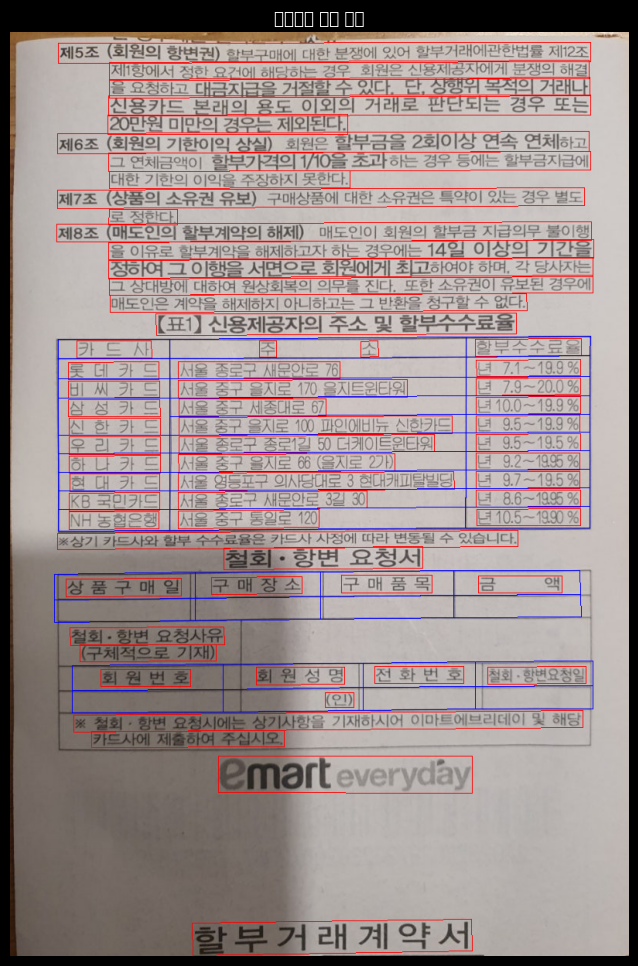

In [13]:
# 로컬 파일 분석
# local_file_path = "../samples/receipt.jpg"
local_file_path = "../samples/receipt2.jpg"
# local_file_path = "../samples/label_sticker.jpg"
# local_file_path = "../samples/egypt.pdf"

try:
    # 이미지인 경우 표시
    display_local_image(local_file_path)

    # 파일 읽기
    with open(local_file_path, "rb") as f:
        document_content = f.read()

    print(f"로컬 파일 '{local_file_path}' 분석 중...")

    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-layout", body=document_content, pages="1-10"
    )

    result = poller.result()

    print(f"분석 완료: {len(result.pages)} 페이지 처리됨")

    # 결과 시각화
    visualize_layout_results(
        result,
        (
            local_file_path
            if local_file_path.lower().endswith(
                (".png", ".jpg", ".jpeg", ".bmp", ".gif")
            )
            else None
        ),
    )

except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {local_file_path}")
    print("samples 폴더가 올바른 위치에 있는지 확인하세요.")
except Exception as e:
    print(f"파일 분석 중 오류 발생: {e}")

### 데이터 프레임으로 변환 후 저장


In [14]:
# 특정 페이지의 특정 테이블 데이터를 DataFrame으로 변환
try:
    import pandas as pd

    if result.tables:
        # 첫 번째 테이블 선택
        table = result.tables[0]

        # 데이터 준비
        data = []
        # 빈 행렬 생성
        table_data = [
            [None for _ in range(table.column_count)] for _ in range(table.row_count)
        ]

        # 셀 데이터 채우기
        for cell in table.cells:
            row_idx = cell.row_index
            col_idx = cell.column_index
            table_data[row_idx][col_idx] = cell.content

        # DataFrame 생성
        df = pd.DataFrame(table_data)

        if len(df) > 0:
            df.columns = df.iloc[0]
            df = df[1:]

        print("\n=== 첫 번째 테이블 DataFrame ===")
        display(df.head())

        # CSV로 저장
        csv_path = "extracted_table.csv"
        df.to_csv(csv_path, index=False)
        print(f"테이블이 {csv_path}로 저장되었습니다.")
    else:
        print("\n테이블이 없어 DataFrame을 생성할 수 없습니다.")
except ImportError:
    print("pandas가 설치되어 있지 않아 DataFrame 변환을 건너뜁니다.")
except Exception as e:
    print(f"DataFrame 변환 중 오류 발생: {e}")


=== 첫 번째 테이블 DataFrame ===


,카 드 사,주 소,할부수수료율
1,롯데 카드,서울 종로구 새문안로 76,년 7.1~19.9 %
2,비 씨 카드,서울 중구 을지로 170 을지트윈타워,년 7.9~20.0 %
3,삼성 카 드 신한카드,서울 중구 세종대로 67,년 10.0~19.9 %
4,None,서울 중구 을지로 100 파인에비뉴 신한카드,년 9.5~19.9 %
5,우리 카드,서울 종로구 종로1길 50 더케이트윈타워,년 9.5~19.5 %


테이블이 extracted_table.csv로 저장되었습니다.


### JSON 파일로 메타데이터 저장


In [15]:
# JSON 으로 메타데이터 저장하기
import json

try:

    def simplify_object(obj):
        # 객체가 딕셔너리로 변환 가능한 경우
        if hasattr(obj, "__dict__"):
            return obj.__dict__

        elif isinstance(obj, list):
            return [simplify_object(item) for item in obj]
        # 기본 자료형으로 변환 불가능한 경우 문자열로 변환
        return str(obj)

    # 결과 저장
    with open("analysis_result.json", "w", encoding="utf-8") as f:
        json.dump(result, f, default=simplify_object, ensure_ascii=False, indent=2)

    print("\n분석 결과가 analysis_result.json 파일로 저장되었습니다.")

except Exception as e:
    print(f"JSON 저장 중 오류 발생: {e}")


분석 결과가 analysis_result.json 파일로 저장되었습니다.
